In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from collections import Counter
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_auc_score, accuracy_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
from util.isoelectric_point import isoelectric_points

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

# Problem Statement

There are influenza viruses that are collected from the "environment", or have an "unknown" host. How do we infer which hosts it came from? Well, that sounds like a **Classification** problem. 

In [8]:
# Load the sequences into memory
sequences = [s for s in SeqIO.parse('data/20160127_HA_prediction.fasta', 'fasta') if len(s.seq) == 566]  # we are cheating and not bothering with an alignment.
len(sequences)

31648

In [9]:
# Load the sequence IDs into memory
seqids = [s.id for s in SeqIO.parse('data/20160127_HA_prediction.fasta', 'fasta') if len(s.seq) == 566]
len(seqids)

31648

In [10]:
# Cast the sequences as a MultipleSeqAlignment object, and then turn that into a pandas DataFrame. 
# Note: this cell takes a while.
seq_aln = MultipleSeqAlignment(sequences)
seq_df = pd.DataFrame(np.array(seq_aln))
seq_df.head()

,0,1,2,3,4,5,6,7,8,9,...,556,557,558,559,560,561,562,563,564,565
0,M,K,A,R,L,L,V,L,L,C,...,N,G,S,L,Q,C,R,I,C,I
1,M,K,A,R,L,L,V,L,L,C,...,N,G,S,L,Q,C,R,I,C,I
2,M,K,A,I,L,V,V,L,L,Y,...,N,G,S,L,Q,C,R,I,C,I
3,M,K,A,I,L,V,V,L,L,Y,...,N,G,S,L,Q,C,R,I,C,I
4,M,K,A,I,L,V,V,L,L,Y,...,N,G,S,L,Q,C,R,I,C,I


In [11]:
# Transform the df into isoelectric point features.
seq_feats = seq_df.replace(isoelectric_points.keys(), isoelectric_points.values())
seq_feats.index = seqids
seq_feats.head()

,0,1,2,3,4,5,6,7,8,9,...,556,557,558,559,560,561,562,563,564,565
CY021709,5.74,9.74,6.11,10.76,6.04,6.04,6.02,6.04,6.04,5.02,...,10.76,6.06,5.68,6.04,5.65,5.02,10.76,6.04,5.02,6.04
CY020285,5.74,9.74,6.11,10.76,6.04,6.04,6.02,6.04,6.04,5.02,...,10.76,6.06,5.68,6.04,5.65,5.02,10.76,6.04,5.02,6.04
CY083910,5.74,9.74,6.11,6.04,6.04,6.02,6.02,6.04,6.04,5.63,...,10.76,6.06,5.68,6.04,5.65,5.02,10.76,6.04,5.02,6.04
CY063606,5.74,9.74,6.11,6.04,6.04,6.02,6.02,6.04,6.04,5.63,...,10.76,6.06,5.68,6.04,5.65,5.02,10.76,6.04,5.02,6.04
CY083776,5.74,9.74,6.11,6.04,6.04,6.02,6.02,6.04,6.04,5.63,...,10.76,6.06,5.68,6.04,5.65,5.02,10.76,6.04,5.02,6.04


In [12]:
# Quick check to make sure that we have no strings:
for c in seq_feats.columns:
    letters = set(seq_feats[c])
    for item in letters:
        assert not isinstance(item, str)

In [13]:
# Let us now load our labels.
labels = pd.read_csv('data/20160127_HA_prediction.csv', parse_dates=['Collection Date'])
labels['Host Species'] = labels['Host Species'].str.replace('IRD:', '').str.replace('/Avian', '')
labels['Sequence Accession'] = labels['Sequence Accession'].str.replace('*', '')
labels.set_index('Sequence Accession', inplace=True)
labels.head()

,Name,Complete Genome,Segment,Segment Length,Subtype,Collection Date,Host Species,Country,State/Province,Flu Season,Strain Name
Sequence Accession,,,,,,,,,,,
K00429,HA,No,4,1730,H7N7,1980,Sea Mammal,USA,Massachusetts,-N/A-,A/seal/Mass/1/1980
J02176,HA,Yes,4,1775,H1N1,1933,Human,United Kingdom,-N/A-,-N/A-,A/WSN/1933
CY021709,HA,Yes,4,1751,H1N1,1945,Human,USA,Texas,-N/A-,A/AA/Huston/1945
CY020285,HA,Yes,4,1741,H1N1,1943,Human,USA,Unknown,-N/A-,A/AA/Marton/1943
CY083910,HA,Yes,4,1752,H1N1,11/23/2009,Human,Denmark,-N/A-,09-10,A/Aalborg/INS132/2009(H1N1)


In [14]:
# Let's join in the labels so that we have everything in one big massive table.
data_matrix = seq_feats.join(labels['Host Species'], how='inner')
data_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,557,558,559,560,561,562,563,564,565,Host Species
CY021709,5.74,9.74,6.11,10.76,6.04,6.04,6.02,6.04,6.04,5.02,...,6.06,5.68,6.04,5.65,5.02,10.76,6.04,5.02,6.04,Human
CY020285,5.74,9.74,6.11,10.76,6.04,6.04,6.02,6.04,6.04,5.02,...,6.06,5.68,6.04,5.65,5.02,10.76,6.04,5.02,6.04,Human
CY083910,5.74,9.74,6.11,6.04,6.04,6.02,6.02,6.04,6.04,5.63,...,6.06,5.68,6.04,5.65,5.02,10.76,6.04,5.02,6.04,Human
CY063606,5.74,9.74,6.11,6.04,6.04,6.02,6.02,6.04,6.04,5.63,...,6.06,5.68,6.04,5.65,5.02,10.76,6.04,5.02,6.04,Human
CY083776,5.74,9.74,6.11,6.04,6.04,6.02,6.02,6.04,6.04,5.63,...,6.06,5.68,6.04,5.65,5.02,10.76,6.04,5.02,6.04,Human


In [15]:
# Quickly inspect the different labels under "host species"
# set(data_matrix['Host Species'])

In [16]:
# We will want to predict the labels for: "Avian", "Bird", "Environment", "Unknown", "null"
unknown_labels = ['Avian', 'Bird', 'Environment', 'Unknown', 'null']
known_labels = set(data_matrix['Host Species']) - set(unknown_labels)

In [17]:
# Let's further split the data into the "unknowns" and the "knowns"
unknowns = data_matrix[data_matrix['Host Species'].isin(unknown_labels)]
knowns = data_matrix[data_matrix['Host Species'].isin(known_labels)]

In [18]:
# Finally, we want to convert the known host species into a matrix of 1s and 0s, so that we can use them as inputs
# to the training algorithm.

lb = LabelBinarizer()
lb.fit([s for s in known_labels])
lb.transform(knowns['Host Species'])  # note: this has not done anything to the original data.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Train/Test Split

We're almost ready for training a machine learning model to classify the unknown hosts based on their sequence.

Here's the proper procedure.

1. Split the labelled data into a training and testing set. (~70 train/30 test to 80 train/20 test)
1. Train and evaluate a model on the training set.
1. Make predictions on the testing set, evaluate the model on testing set accuracy.

This procedure is known as cross-validation, and is a powerful, yet cheap & easy method for evaluating how good a particular supervised learning model works.

In [19]:
# Split the data into a training and testing set.
X_cols = [i for i in range(0,566)]
X = knowns[X_cols]
Y = lb.transform(knowns['Host Species'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [20]:
# Train a Random Forest Classifier.
# Note: This cell takes a while; any questions?

# Initialize the classifier object.
clf = RandomForestClassifier()

# Train (i.e. "fit") the classifier to the training Xs and Ys
clf.fit(X_train, Y_train)

# Make predictions on the test X
preds = clf.predict(X_test)
preds

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [21]:
lb.inverse_transform(preds)

array(['Swine', 'Human', 'Human', ..., 'Human', 'Mallard', 'Swine'], 
      dtype='<U27')

### How do we evaluate how good the classification task performed?

For binary classification, the Receiver-Operator Characteristic curve is a great way to evaluate a classification task.

For multi-label classification, which is the case we have here, accuracy score is a great starting place.

In [22]:
# Let's first take a look at the accuracy score: the fraction that were classified correctly.
accuracy_score(lb.inverse_transform(Y_test), lb.inverse_transform(preds))

0.92748333862265953

### What about those sequences for which the hosts were unknown?

We can run the `predict(unknown_Xs)` to predict what their hosts were likely to be, given their sequence.

In [23]:
unknown_preds = clf.predict(unknowns[X_cols])  # make predictions; note: these are still dummy-encoded.
unknown_preds = lb.inverse_transform(unknown_preds)  # convert dummy-encodings back to string labels.
unknown_preds

array(['American Black Duck', 'Guineafowl', 'Duck', 'Duck', 'Duck', 'Duck',
       'Mallard', 'Duck', 'Duck', 'Mallard', 'American Black Duck',
       'Herring Gull', 'Laughing Gull', 'Shorebird', 'American Black Duck',
       'American Black Duck', 'Human', 'Human', 'Duck', 'Duck', 'Duck',
       'Duck', 'Duck', 'Duck', 'Duck', 'Duck', 'American Black Duck',
       'American Black Duck', 'American Black Duck', 'Duck', 'Mallard',
       'Mallard', 'Duck', 'American Black Duck', 'Mallard', 'Mallard',
       'Mallard', 'Mallard', 'Mallard', 'Mallard', 'Mallard',
       'American Black Duck', 'American Black Duck', 'American Black Duck',
       'American Black Duck', 'American Black Duck', 'American Black Duck',
       'American Black Duck', 'American Black Duck', 'American Black Duck',
       'American Black Duck', 'American Black Duck', 'American Black Duck',
       'American Black Duck', 'American Black Duck', 'American Black Duck',
       'American Black Duck', 'American Black Duck', 

What this gives us is the class label with the highest probability of being the correct one. 

While we will not do this here, at this point, it would be a good idea to double-check your work with a sanity check. Are the sequences that are predicted to be `Human` truly of a close sequence similarity to actual `Human` sequences? You may want to do a Multiple Sequence Alignment, or you might want to simply compute the Levenshtein or Hamming distance between the two sequences, as a sanity check.

### How do we interpret what the classifier learned?

Depending on the classifier used, you can peer inside the model to get a feel for what the classifier learned about the features that best predict the class label.

The `RandomForestClassifier` provides a `feature_importances_` attribute that we can access and plot.

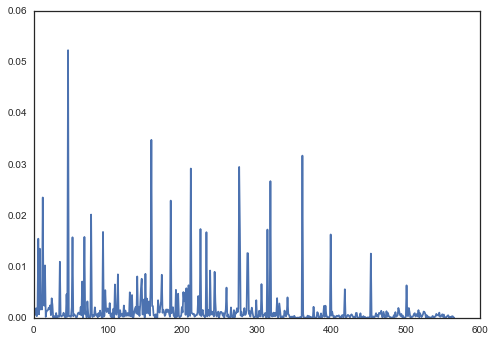

In [25]:
plt.plot(clf.feature_importances_)

The interpretation here is that the positions with greater "feature importance" were better at predicting the host class.

## Hands-On Exercises

Now that you've seen the coding pattern for classification using the `RandomForestClassifier`, try it out for the `DecisionTreeClassifier`, evaluate its accuracy, and if applicable, try doing the "peering inside" of the model.

## Conclusions

- Classification: it's all about using features to predict a label.
    - `classifier.fit(train_data)`
    - `classifier.predict(test_data)`
- Split your data into training and testing sets.

# Bonus exercise (time permitting)

Can you train a model to classify the two types of influenza H1N1 sequences from the previous notebook?